In [1]:
# Import required libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
from plotly.subplots import make_subplots
from pymongo import MongoClient
from collections import Counter, defaultdict
import os
import warnings
import sys
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('default')
sns.set_palette("husl")

library_path = os.path.abspath('..')
if library_path not in sys.path:
    sys.path.append(library_path)

PLOTS_PATH = os.path.join(library_path, 'plots')

print("Libraries imported successfully!")
print(f"Current working directory: {os.getcwd()}")

Libraries imported successfully!
Current working directory: /home/luis/CGE/voice_db/analysis_notebooks


In [2]:
# Connect to MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client["Diagnosis_Severity_PD_Voice"]
collection = db["studies"]

# Load all studies
print("🔄 Loading studies from MongoDB...")
field_to_extract = {
    "doi"             : 1, 
    "journal"         : 1, 
    "authors"         : 1, 
    "publication_type": 1, 
    "year"            : 1, 
    "study_id"        : 1,
    "problem"         : 1,
    "ml_problem_type" : 1,
    '_id'             : 0
}  # 1 = include, 0 = exclude
studies_cursor = collection.find({}, field_to_extract)
studies_list = list(studies_cursor)

print(f"📊 Total studies loaded: {len(studies_list)}")
print(f"📄 Sample document keys: {list(studies_list[0].keys()) if studies_list else 'No documents found'}")
print("ℹ️  Note: Each document represents a study - we'll aggregate these into papers for analysis")

🔄 Loading studies from MongoDB...
📊 Total studies loaded: 381
📄 Sample document keys: ['authors', 'publication_type', 'journal', 'year', 'doi', 'study_id', 'ml_problem_type', 'problem']
ℹ️  Note: Each document represents a study - we'll aggregate these into papers for analysis


In [3]:
studies_df = pd.DataFrame(studies_list)
studies_df.head()

,authors,publication_type,journal,year,doi,study_id,ml_problem_type,problem
0,"[{'name': 'Shallu Sehgal', 'affiliations': [{'...",Journal,SN Applied Sciences,2020,110.1007/s42452-020-2826-9,110.1007/s42452-020-2826-9_1,[Classification: Binary ],Parkinson's disease diagnosis
1,"[{'name': 'Laiba Zahid', 'affiliations': [{'in...",Journal,IEEE Access,2020,10.1109/ACCESS.2020.2974008,10.1109/ACCESS.2020.2974008_1,[Classification: Binary ],Parkinson's disease diagnosis
2,"[{'name': 'Liang Zhang', 'affiliations': [{'in...",Journal,JMIR Medical Informatics,2020,10.2196/18689,10.2196/18689_1,[Classification: Binary ],Parkinson's disease diagnosis
3,"[{'name': 'B. Sai Jahnavi', 'affiliations': [{...",Journal,Journal of Intelligent & Fuzzy Systems,2020,10.3233/JIFS-179714,10.3233/JIFS-179714_1,[Classification: Binary ],Parkinson's disease diagnosis
4,"[{'name': 'Biswajit Karan', 'affiliations': [{...",Journal,Biocybernetics and Biomedical Engineering,2020,10.1016/j.bbe.2019.05.005,10.1016/j.bbe.2019.05.005_2,[Classification: Binary ],Parkinson's disease diagnosis


In [4]:
print(f"Total articles in database: {studies_df['doi'].nunique()}")
print(f"Total studies in database: {len(studies_df)}")

Total articles in database: 260
Total studies in database: 381


In [5]:
print("Distribution in conference/journal papers:")
abs_count = studies_df['publication_type'].value_counts()
rel_count = studies_df['publication_type'].value_counts(normalize=True) * 100
distribution_df = pd.DataFrame({'Absolute Count': abs_count, 'Relative Count (%)': rel_count})
print(distribution_df)

Distribution in conference/journal papers:
                  Absolute Count  Relative Count (%)
publication_type                                    
Journal                      332           87.139108
Conference                    49           12.860892


# Distribution by problem (Diagnosis vs Severity).

In [6]:
# Group studies by 'doi' and aggregate 'problem' values into a list
problems_by_doi = studies_df.groupby('doi')['problem'].apply(list).reset_index()
problems_by_doi.head()
problems_by_doi["diagnosis"] = problems_by_doi["problem"].apply(lambda x: "Parkinson's disease diagnosis" in x)
problems_by_doi["severity"] = problems_by_doi["problem"].apply(lambda x: "Parkinson's disease severity stage classification" in x)
problems_by_doi.head()

,doi,problem,diagnosis,severity
0,10.1002/cpe.6419,[Parkinson's disease diagnosis],True,False
1,10.1002/eng2.13091,"[Parkinson's disease diagnosis, Parkinson's di...",True,False
2,10.1007/978-3-030-31129-2_15,[Parkinson's disease severity stage classifica...,False,True
3,10.1007/978-3-030-82153-1_34,"[Parkinson's disease diagnosis, Parkinson's di...",True,False
4,10.1007/978-3-030-86993-9_44,[Parkinson's disease diagnosis],True,False


In [7]:
only_diagnosis = problems_by_doi[problems_by_doi['diagnosis'] & ~problems_by_doi['severity']].shape[0]
print(f"Papers addressing only diagnosis: {only_diagnosis} ({only_diagnosis / problems_by_doi.shape[0] * 100:.2f}%)")
only_severity = problems_by_doi[~problems_by_doi['diagnosis'] & problems_by_doi['severity']].shape[0]
print(f"Papers addressing only severity: {only_severity} ({only_severity / problems_by_doi.shape[0] * 100:.2f}%)")
both = problems_by_doi[problems_by_doi['diagnosis'] & problems_by_doi['severity']].shape[0]
print(f"Papers addressing both diagnosis and severity: {both} ({both / problems_by_doi.shape[0] * 100:.2f}%)")

Papers addressing only diagnosis: 228 (87.69%)
Papers addressing only severity: 27 (10.38%)
Papers addressing both diagnosis and severity: 5 (1.92%)


In [8]:
papers_df = studies_df.groupby('doi', as_index=False).agg({
    'journal': 'first',
    'authors': 'first',
    'year': 'first',
})
papers_df.head()

,doi,journal,authors,year
0,10.1002/cpe.6419,Concurrency and Computation: Practice and Expe...,"[{'name': 'Karthikeyan Harimoorthy', 'affiliat...",2021
1,10.1002/eng2.13091,Engineering Reports,"[{'name': 'Fahmida Khanom', 'affiliations': [{...",2025
2,10.1007/978-3-030-31129-2_15,Proceedings of the International Conference on...,"[{'name': 'Ahmed M. Anter', 'affiliations': [{...",2020
3,10.1007/978-3-030-82153-1_34,"Knowledge Science, Engineering and Management....","[{'name': 'Rania Khaskhoussy', 'affiliations':...",2021
4,10.1007/978-3-030-86993-9_44,Brain Informatics. BI,"[{'name': 'Nazmun Nahar', 'affiliations': [{'i...",2021


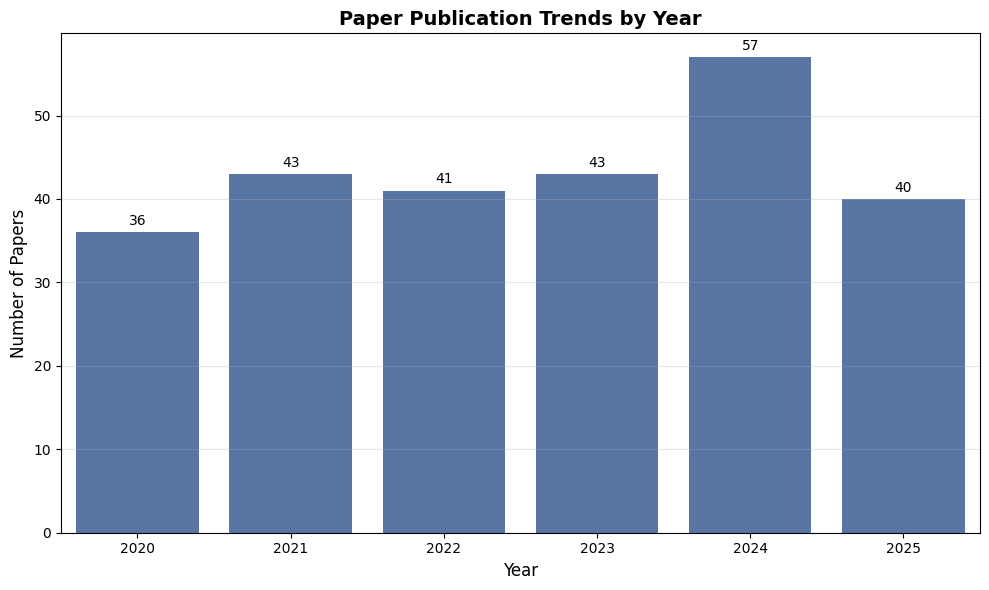

In [9]:
year_counts = papers_df['year'].value_counts().sort_index()

# Create bar plot
fig = go.Figure(
    data=[go.Bar(x=year_counts.index, y=year_counts.values, text=year_counts.values, textposition="outside")]
)

fig.update_layout(
    title="Paper Publication Trends by Year",
    xaxis_title="Year",
    yaxis_title="Number of Papers",
    template="plotly_white",
    bargap=0.2,  # space between bars
)

fig.show()

# Create seaborn bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=year_counts.index, y=year_counts.values, color="#4C72B0")

# Add value labels on bars
for i, v in enumerate(year_counts.values):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom')

plt.title("Paper Publication Trends by Year", fontsize=14, fontweight='bold')
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Papers", fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_PATH, 'paper_publication_trends_by_year.svg'), dpi=600)
plt.show()

# Journal Analysis

In [10]:
journal_count = papers_df['journal'].value_counts()

In [11]:
print(f"Total unique journals: {journal_count.shape[0]}")
print(f"Journals that have published only one paper: {sum(journal_count == 1)}")

Total unique journals: 140
Journals that have published only one paper: 108


In [12]:

import textwrap

def break_long_names(name, max_len=22, max_lines=3):
    wrapped = textwrap.wrap(
        name,
        width=max_len,
        break_long_words=False,
        break_on_hyphens=False
    )

    # Limit number of lines
    if len(wrapped) > max_lines:
        wrapped = wrapped[:max_lines]
        wrapped[-1] += "…"

    return "\n".join(wrapped)

top10_journals = journal_count.head(10)

journal_labels = [break_long_names(j) for j in top10_journals.index]

fig = px.bar(
    x=top10_journals.values[::-1],
    y=journal_labels[::-1],   # reverse order
    orientation='h',
    title='Top 10 Journals by Number of Papers',
    labels={'x': 'Number of Papers', 'y': 'Journal'},
    color_discrete_sequence=['#4C72B0']
)

fig.update_layout(
    font=dict(size=14),
    title_font=dict(size=18),
    plot_bgcolor='white',
    paper_bgcolor='white',
    xaxis=dict(
        showgrid=True,
        gridcolor='#E5E5E5'
    ),
    yaxis=dict(showgrid=False)
)

fig.update_traces(marker=dict(line=dict(width=1, color='black')))

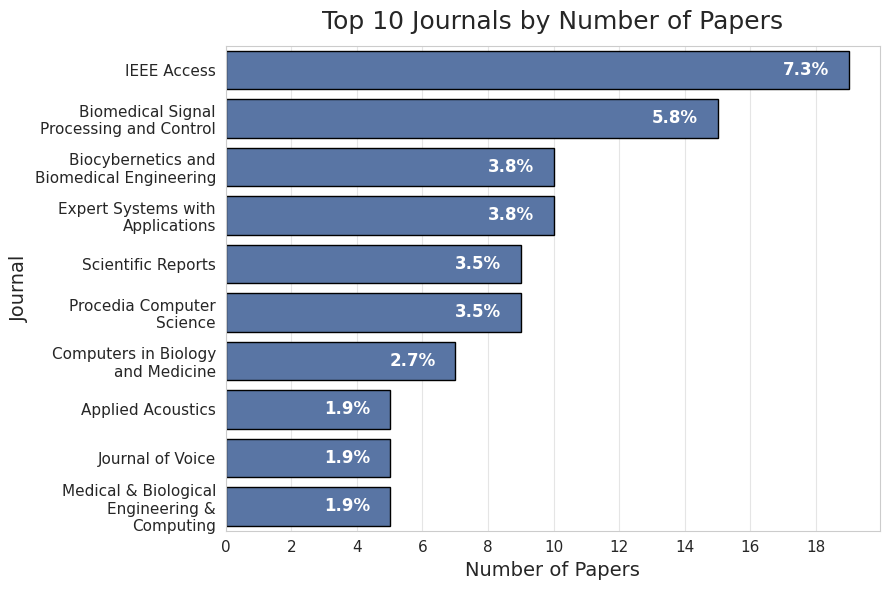

In [13]:
from matplotlib.ticker import MaxNLocator

# Seaborn style
sns.set_style("whitegrid")

# Figure size (single-column journal size)
plt.figure(figsize=(9, 6))

# Calculate percentages
percentages = (top10_journals.values / len(papers_df)) * 100

# Bar plot
ax = sns.barplot(
    x=top10_journals.values,
    y=journal_labels,
    color="#4C72B0",
    edgecolor="black"
)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# Labels and title
ax.set_title("Top 10 Journals by Number of Papers", fontsize=18, pad=12)
ax.set_xlabel("Number of Papers", fontsize=14)
ax.set_ylabel("Journal", fontsize=14)

# Ticks
ax.tick_params(axis='both', labelsize=11)

# Add value and percentage labels on bars
for i, (v, pct) in enumerate(zip(top10_journals.values, percentages)):
    ax.text(v - 2, i, f"{pct:.1f}%", va='center', ha='left', fontsize=12, fontweight='bold', color='white')

# Improve grid appearance
ax.grid(axis='x', color="#E5E5E5")
ax.grid(axis='y', visible=False)

# Tight layout for clean export
plt.tight_layout()

# ✅ Save as SVG (vector format)
plt.savefig(os.path.join(PLOTS_PATH, 'top10_journals.svg'), dpi=600)

plt.show()

In [14]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# ================================
# Analysis: Papers published in top journals
# ================================

print("📊 PAPERS IN TOP JOURNALS ANALYSIS")
print("=" * 45)

# --- Robust journal cleaning (fixes NaN + empty strings)
journal_series = papers_df['journal'].replace('', pd.NA).dropna()

journal_counts_sorted = journal_series.value_counts()
total_papers_with_journal = len(journal_series)

# --- Top ranges
top_ranges = [10, 15, 20]

print(f"\n📰 Total papers with journal information: {total_papers_with_journal}")
print(f"📰 Total unique journals: {len(journal_counts_sorted)}")

# --- Summary statistics for Top 10, 15, 20
for top_n in top_ranges:
    if len(journal_counts_sorted) >= top_n:
        top_journals = journal_counts_sorted.head(top_n)
        papers_in_top = top_journals.sum()
        percentage = (papers_in_top / total_papers_with_journal) * 100

        print(f"\n🏆 TOP {top_n} JOURNALS:")
        print(f"  • Papers published: {papers_in_top}/{total_papers_with_journal} ({percentage:.1f}%)")
        print(f"  • Average papers per journal: {papers_in_top / top_n:.1f}")

        if top_n == 10:
            print(f"  • Individual journal breakdown:")
            for i, (journal, count) in enumerate(top_journals.items(), 1):
                print(f"    {i:2d}. {journal}: {count} papers")
    else:
        print(f"\n⚠️  Only {len(journal_counts_sorted)} journals available (less than {top_n})")

# ================================
# Efficient cumulative computation (Top 20)
# ================================

top20_counts = journal_counts_sorted.head(20)
cumulative_papers = top20_counts.cumsum().values.tolist()
cumulative_percentages = (100 * top20_counts.cumsum() / total_papers_with_journal).values.tolist()
journal_positions = list(range(1, len(top20_counts) + 1))

# ================================
# Plotly Visualization
# ================================

fig = go.Figure()

# Cumulative curve
fig.add_trace(go.Scatter(
    x=journal_positions,
    y=cumulative_percentages,
    mode='lines+markers',
    name='Cumulative Percentage',
    line=dict(width=3),
    marker=dict(size=8),
))

# Color-blind safe reference lines
colors = ['#4C72B0', '#DD8452', '#55A868']
labels = ['Top 10', 'Top 15', 'Top 20']

for top_n, color, label in zip(top_ranges, colors, labels):
    if top_n <= len(journal_positions):
        fig.add_vline(
            x=top_n,
            line_dash="dash",
            line_color=color,
            line_width=2
        )

        fig.add_annotation(
            x=top_n,
            y=cumulative_percentages[top_n - 1],
            text=f"{label}: {cumulative_percentages[top_n - 1]:.1f}%",
            showarrow=True,
            arrowhead=2,
            ax=25,
            ay=-35,
            font=dict(size=12),
        )

# Publication-grade layout
fig.update_layout(
    title="Cumulative Percentage of Papers Published by Top Journals",
    xaxis_title="Number of Top Journals",
    yaxis_title="Cumulative Percentage of Papers (%)",
    template="plotly_white",
    font=dict(size=14),
    title_font=dict(size=18),
    yaxis=dict(range=[0, 100]),
    height=500,
    showlegend=False
)

fig.show()

# ================================
# Summary Table (Clean Formatting)
# ================================

print(f"\n📊 SUMMARY TABLE:")
print("=" * 55)
print(f"{'Journals':<10} {'Papers':>10} {'Percentage':>12} {'Avg/Journal':>14}")
print("-" * 55)

for top_n in top_ranges:
    if len(journal_counts_sorted) >= top_n:
        papers_in_top = journal_counts_sorted.head(top_n).sum()
        percentage = (papers_in_top / total_papers_with_journal) * 100
        avg_per_journal = papers_in_top / top_n

        print(f"Top {top_n:<6} {papers_in_top:>10d} {percentage:>11.1f}% {avg_per_journal:>13.1f}")

# ================================
# Key Insights
# ================================

print(f"\n🔍 Key Insights:")

if len(journal_counts_sorted) >= 20:
    top10_papers = journal_counts_sorted.head(10).sum()
    top20_papers = journal_counts_sorted.head(20).sum()
    concentration_ratio = (top10_papers / top20_papers) * 100

    print(f"  • Top 10 journals account for {concentration_ratio:.1f}% of top 20 journals' papers")

remaining_journals = len(journal_counts_sorted) - 20 if len(journal_counts_sorted) > 20 else 0

if remaining_journals > 0:
    remaining_papers = total_papers_with_journal - top20_counts.sum()
    print(f"  • Remaining {remaining_journals} journals published "
          f"{remaining_papers} papers ({remaining_papers / total_papers_with_journal * 100:.1f}%)")


📊 PAPERS IN TOP JOURNALS ANALYSIS

📰 Total papers with journal information: 260
📰 Total unique journals: 140

🏆 TOP 10 JOURNALS:
  • Papers published: 94/260 (36.2%)
  • Average papers per journal: 9.4
  • Individual journal breakdown:
     1. IEEE Access: 19 papers
     2. Biomedical Signal Processing and Control: 15 papers
     3. Biocybernetics and Biomedical Engineering: 10 papers
     4. Expert Systems with Applications: 10 papers
     5. Scientific Reports: 9 papers
     6. Procedia Computer Science: 9 papers
     7. Computers in Biology and Medicine: 7 papers
     8. Applied Acoustics: 5 papers
     9. Journal of Voice: 5 papers
    10. Medical & Biological Engineering & Computing: 5 papers

🏆 TOP 15 JOURNALS:
  • Papers published: 115/260 (44.2%)
  • Average papers per journal: 7.7

🏆 TOP 20 JOURNALS:
  • Papers published: 128/260 (49.2%)
  • Average papers per journal: 6.4



📊 SUMMARY TABLE:
Journals       Papers   Percentage    Avg/Journal
-------------------------------------------------------
Top 10             94        36.2%           9.4
Top 15            115        44.2%           7.7
Top 20            128        49.2%           6.4

🔍 Key Insights:
  • Top 10 journals account for 73.4% of top 20 journals' papers
  • Remaining 120 journals published 132 papers (50.8%)


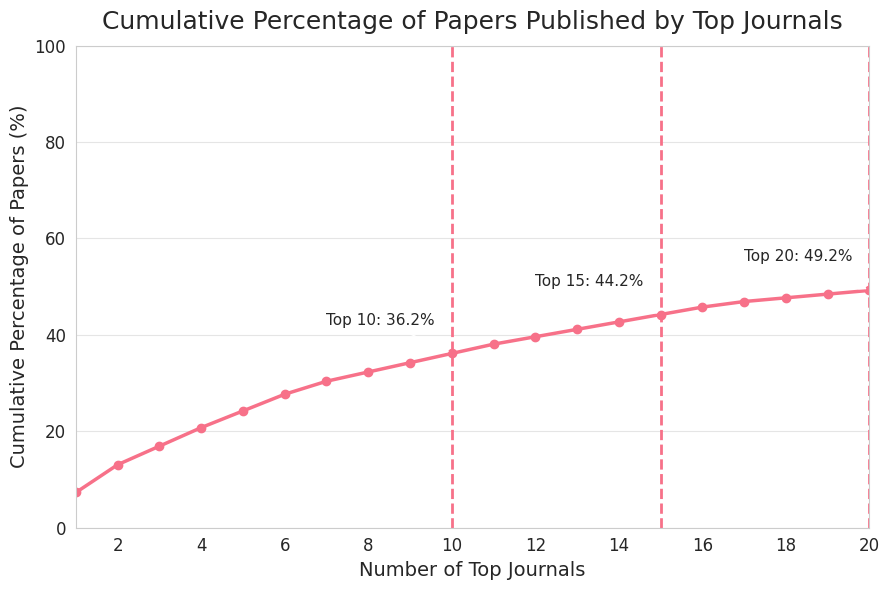

In [15]:
# ================================
# Robust journal cleaning
# ================================

journal_series = papers_df['journal'].replace('', pd.NA).dropna()
journal_counts_sorted = journal_series.value_counts()
total_papers_with_journal = len(journal_series)

top_ranges = [10, 15, 20]

# ================================
# Efficient cumulative computation (Top 20)
# ================================

top20_counts = journal_counts_sorted.head(20)
cumulative_papers = top20_counts.cumsum()
cumulative_percentages = 100 * cumulative_papers / total_papers_with_journal
journal_positions = np.arange(1, len(top20_counts) + 1)

# ================================
# Seaborn / Matplotlib plot
# ================================

sns.set_style("whitegrid")

plt.figure(figsize=(9, 6))  # Single-column journal size
ax = plt.gca()

# Cumulative line
ax.plot(
    journal_positions,
    cumulative_percentages,
    marker='o',
    linewidth=2.5
)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# Color-blind–safe vertical reference lines
colors = ['#4C72B0', '#DD8452', '#55A868']
labels = ['Top 10', 'Top 15', 'Top 20']

for top_n, color, label in zip(top_ranges, colors, labels):
    if top_n <= len(journal_positions):
        y_val = cumulative_percentages.iloc[top_n - 1]

        ax.axvline(
            x=top_n,
            linestyle='--',
            linewidth=2
        )

        ax.annotate(
            f"{label}: {y_val:.1f}%",
            xy=(top_n, y_val),
            xytext=(top_n - 3, y_val + 6),
            arrowprops=dict(arrowstyle="->"),
            fontsize=11
        )

# Axis labels and title (journal safe: no emoji)
ax.set_title(
    "Cumulative Percentage of Papers Published by Top Journals",
    fontsize=18,
    pad=12
)
ax.set_xlabel("Number of Top Journals", fontsize=14)
ax.set_ylabel("Cumulative Percentage of Papers (%)", fontsize=14)

# Axis limits
ax.set_xlim(1, len(journal_positions))
ax.set_ylim(0, 100)

# Ticks
ax.tick_params(axis='both', labelsize=12)

# Grid refinement
ax.grid(axis='x', visible=False)
ax.grid(axis='y', color="#E5E5E5")

# Layout
plt.tight_layout()

# ================================
# Export (publication format)
# ================================

plt.savefig(os.path.join(PLOTS_PATH, "cumulative_top_journals.svg"), format="svg", dpi=600)
plt.savefig(os.path.join(PLOTS_PATH, "cumulative_top_journals.pdf"), format="pdf", dpi=600)

plt.show()


In [23]:
def get_affiliation(author):
    # Case 1: Missing or NaN
    if author is None or pd.isna(author):
        return None

    # Case 2: If it's a string, no structured affiliation available
    if isinstance(author, str):
        return None

    # Case 3: Must be a dictionary from here
    if not isinstance(author, dict):
        return None

    # Case 4: OpenAlex-style structure
    if "affiliations" in author and isinstance(author["affiliations"], list) and len(author["affiliations"]) > 0:
        first_aff = author["affiliations"][0]
        if isinstance(first_aff, dict):
            return first_aff.get("institution")

    # Case 5: Alternative structure
    if "affiliation" in author and isinstance(author["affiliation"], list) and len(author["affiliation"]) > 0:
        first_aff = author["affiliation"][0]
        if isinstance(first_aff, dict):
            return first_aff.get("institution")

    return None

def get_country(author):
    # Case 1: Missing or NaN
    if author is None or pd.isna(author):
        return None

    # Case 2: If it's a string, no structured affiliation available
    if isinstance(author, str):
        return None

    # Case 3: Must be a dictionary from here
    if not isinstance(author, dict):
        return None

    # Case 4: OpenAlex-style structure
    if "affiliations" in author and isinstance(author["affiliations"], list) and len(author["affiliations"]) > 0:
        first_aff = author["affiliations"][0]
        if isinstance(first_aff, dict):
            return first_aff.get("country")

    # Case 5: Alternative structure
    if "affiliation" in author and isinstance(author["affiliation"], list) and len(author["affiliation"]) > 0:
        first_aff = author["affiliation"][0]
        if isinstance(first_aff, dict):
            return first_aff.get("country")

    return None


In [24]:
authors_df = papers_df.explode('authors')
authors_df["author"] = authors_df["authors"].apply(lambda x: x['name'])
authors_df['fst_affiliation'] = authors_df["authors"].apply(lambda x: get_affiliation(x))
authors_df['fst_country'] = authors_df["authors"].apply(lambda x: get_country(x))
authors_df

,doi,journal,authors,year,author,fst_affiliation,fst_country
0,10.1002/cpe.6419,Concurrency and Computation: Practice and Expe...,"{'name': 'Karthikeyan Harimoorthy', 'affiliati...",2021,Karthikeyan Harimoorthy,Anna University,India
0,10.1002/cpe.6419,Concurrency and Computation: Practice and Expe...,"{'name': 'Menakadevi Thangavelu', 'affiliation...",2021,Menakadevi Thangavelu,Adhiyamaan College of Engineering,India
1,10.1002/eng2.13091,Engineering Reports,"{'name': 'Fahmida Khanom', 'affiliations': [{'...",2025,Fahmida Khanom,American International University-Bangladesh,Bangladesh
1,10.1002/eng2.13091,Engineering Reports,"{'name': 'Mohammad Shorif Uddin', 'affiliation...",2025,Mohammad Shorif Uddin,Jahangirnagar University,Bangladesh
1,10.1002/eng2.13091,Engineering Reports,"{'name': 'Rafid Mostafiz', 'affiliations': [{'...",2025,Rafid Mostafiz,Noakhali Science and Technology University,Bangladesh
...,...,...,...,...,...,...,...
258,110.1007/s42452-020-2826-9,SN Applied Sciences,"{'name': 'Shirsh Sundaram', 'affiliations': [{...",2020,Shirsh Sundaram,Maharaja Agrasen Institute of Technology,India
258,110.1007/s42452-020-2826-9,SN Applied Sciences,"{'name': 'Arun Bashambu', 'affiliations': [{'i...",2020,Arun Bashambu,Banasthali Vidyapeeth,India
259,doi.org/10.1016/j.eswa.2024.125401,Expert Systems with Applications,"{'name': 'Mario Madruga Escalona', 'affiliatio...",2025,Mario Madruga Escalona,Universidad de Extremadura,Spain
259,doi.org/10.1016/j.eswa.2024.125401,Expert Systems with Applications,"{'name': 'Yolanda Campos-Roca', 'affiliations'...",2025,Yolanda Campos-Roca,Universidad de Extremadura,Spain
